# LSTM Pulsation Tracing

This notebook demonstrates how to apply the trained LSTM network to trace cardiac pulsations in optical waveforms (NIRS, PPG, and DCS). It also illustrates pulse segmentation and waveform averaging to generate representative beats for downstream analysis. For questions, please contact Jingyi Wu (jingyiwu@andrew.cmu.edu).

## General Pipeline
1. Load a 1×N waveform and apply basic preprocessing (resample → scale).
2. Run windowed inference with the trained LSTM to obtain a cleaned/denoised trace.
3. Benchmark against alternative methods such as TDDR and Wavelet filtering.
4. Detect beats (peaks or valleys), segment pulses, and compute averaged waveforms.
5. Visualizations include time trace overlays, segment comparisons, spectrograms, and signal quality index (SNR) time traces.

## Requirements
- Data file containing signal and sampling frequency.
- Trained LSTM weights (stored in the `models/` folder).


## Import packages

In [1]:
# Uncomment the next line to install your repo dependencies.
# !pip install -r requirements_test.txt

In [2]:
import os
import math
import random

import numpy as np
import h5py
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import plotly.io as pio
pio.renderers.default = 'iframe' # this might create a folder named "iframe_figures" and save the interactive plots generated by this script

from utils import * # custom helper functions
color5 = ['#eb5055', '#405FC1', '#ffaa1c', '#62a140', '#9E3AB7'] # Color for plots

## 1. Load pre-trained LSTM model

In [3]:
# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Candidate model files
model_names = [
    'lstm_full_dataset.pt'
]

model_folder = "models/"

# Pick model by index
idx_model = 0
model_name = model_names[idx_model]
print(f"Model selected: {model_name}")

# Initialize model architecture
model = LSTMDetectionModel(n_hid=256, n_layers=1).to(device)

# Load saved weights
state_dict = torch.load(os.path.join(model_folder, model_name), map_location=device)
model.load_state_dict(state_dict)

# Move model to device (redundant but explicit)
model = model.to(device)

model.eval()

print("Model loaded successfully!")

Device: cpu
Model selected: lstm_full_dataset.pt
Model loaded successfully!


/var/folders/x8/2tyh0lwd3v73c3yx2py26lwm0000gn/T/ipykernel_99672/1137976619.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



## 2. Load test data and preprocessing

In this section, we load example experimental datasets used in the paper figures. 

Eight example datasets are provided:
- Two NIRS measurements with artifacts induced by fiber- and head-shaking.
- Four PPG measurements from finger with distinct pulse shapes.
- Two DCS measurements from forhead with distinct pulse shapes.

Users can toggle between them by adjusting the index below.

**Notes:**
- To load your own data, make sure the dimensions are consistent:  
  - `data_pick` should be **1 × time**.  
  - A sampling frequency `fs_data` must be provided.  
- If your `.mat` file uses different field names (e.g., `signal`, `fs`), update the keys accordingly in the loading step.
- We saved the mannuly tuned `amplitude_scale` and `offset` in our dataset. See the proprocessing session for more details, but users will have to adjust these parameters based on their own signal.

In [4]:
test_files = ['nirs_fiber_shaking.mat', # 0
              'nirs_head_shaking.mat', # 1
              'ppg_subject1.mat', # 2
              'ppg_subject2.mat', # 3
              'ppg_subject3.mat', # 4
              'ppg_subject4.mat', # 5
              'dcs_subject1_supine', # 6
              'dcs_subject2_valsava'] # 7

# Pick dataset to test
idx_file = 4
test_file = test_files[idx_file]
print("Test file: " + test_file + " is picked!")

# Build full path and load dataset
test_folder = 'experimental_data/'
test_path = test_folder + test_file
dataset = loadmat(test_path)
print(dataset.keys())

Test file: ppg_subject3.mat is picked!
dict_keys(['__header__', '__version__', '__globals__', 'amplitude_scale', 'fs', 'offset', 'signal', 'time'])


In [5]:
# Extract raw signal (single channel, reshape to row vector)
data_pick = dataset['signal'][0].reshape(-1, 1).T
print(data_pick.shape)  # should be 1 × time

# Extract sampling frequency from the dataset
# Note: if it differs from 50 Hz (training data fs), it will be resampled later
fs_data = dataset['fs'][0][0] * 1.0
print(fs_data)

# Dataset specific parameters for preprocessing.
amplitude_scale = dataset['amplitude_scale'][0][0]
offset = dataset['offset'][0][0]
print(amplitude_scale)
print(offset)

# Figure title based on filename for plotting
figure_title = f"{test_file.removesuffix('.mat')}"
print(figure_title)


(1, 4000)
50.0
1.5
-0.1
ppg_subject3


### Preprocessing
Convert raw intensity to delta optical density (dOD) if necessary:
- Training data were PPG-like waveforms (systolic peak pointing upward).
- Thus, measured DC intensity signals from NIRS need conversion to dOD. For signals already resembling PPG, like pulsatile blood flow from DCS, this conversion is not necessary.
- But, our model will still trace the pulses without this conversion, and users are encouraged to experiment with it.

In [6]:
if idx_file in [0,1]: # these are the NIRS DC measurements
    time_trace_raw = -np.log(data_pick / np.nanmean(data_pick))
else:
    time_trace_raw = data_pick

# For handling nan in data
# eps = 1e-12
# time_trace_raw = -np.log(time_trace_raw_input / (np.nanmean(data_pick) + eps))

Preprocessing steps:

1. Resample to 50 Hz (to match training data).
2. Center signal around zero.
3. Normalize so that pulsations roughly lie in [-1, 1].

Current implementation uses Hilbert transform and envelope detection to auto-scale the pulse amplitude, 
but it is not always perfect. Users may need to manually tune:

  `amplitude_scale` : controls vertical scaling
  
  `offset`          : shifts the center up or down

Practical tips:
   - The current preprocessing method scales/offsets the entire time trace by a constant. In reality, pulse amplitudes can change over time. A more robust approach (e.g., moving mean + moving standard deviation) may be implemented in the future. Users are encouraged to experiment with other normalization methods for potentially improved results. 
   - After normalization, visually check the time trace for appropriate scaling.
   - An additional check is to look at segmented and averaged pulse waveforms 
     (plotted at the end of the script). If normalization is done correctly, both 
     raw and LSTM-processed averaged waveforms should have very similar amplitude and fall roughly within [-1, 1].
   - This step is critical: carefully adjusting scaling leads to much better results.

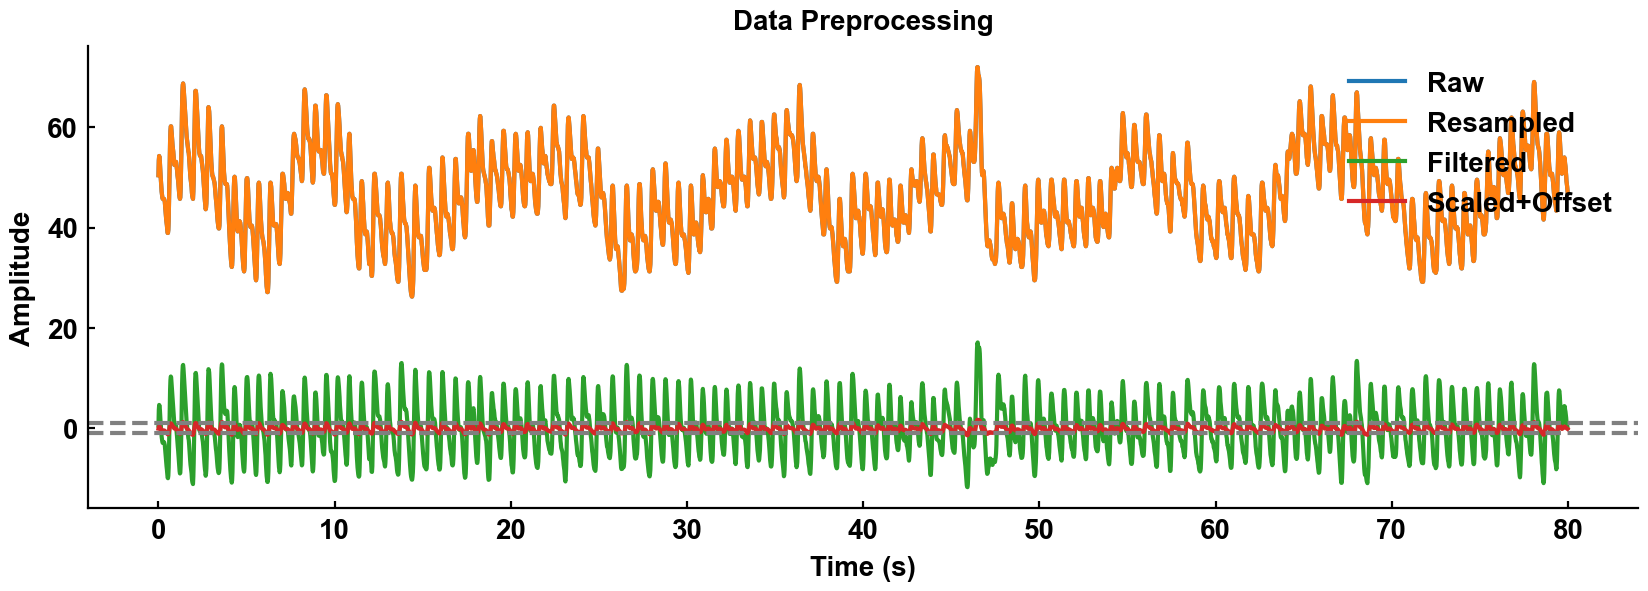

In [7]:
fs_origin = fs_data
fs_target = 50.0 # Training data were sampled at 50 Hz
t_nirs, time_trace, signal_scale = preprocess_signal(time_trace_raw, fs_origin, fs_target, amplitude_scale=amplitude_scale, offset=offset)

## 3. Process signal with LSTM

For input signals of arbitrary length, we first segment them into fixed-length windows (the same size used during training).  
Each segment is processed independently by the trained LSTM model, and then recombined into a full-length time trace.  
Overlapping regions between segments are averaged for smooth reconstruction.

We also compare the raw vs. processed signals, estimate the signal quality index (SNR), and visualize spectrograms before and after processing.


In [8]:
# Segmentation parameters
# Window size must match training data length (1 min at 50 Hz → 3000 samples).
# Overlap size can be adjusted: larger overlap = smoother stitching, more compute.
window_size = 3000
overlap_size = 2000

# Segment the full trace into overlapping windows
segments = segment_time_trace(time_trace, window_size, overlap_size)

# Optional: visualize segmentation
# plot_segments(time_trace, segments, window_size, overlap_size, 
#               "Segmented Time Traces")

# Run the trained LSTM model on each segment
processed_segments = process_segments_with_lstm(model, segments, device)

# Recombine processed segments into a single continuous trace
processed_time_trace = combine_processed_segments(processed_segments, window_size, overlap_size, time_trace.shape[1])


**Compare original vs. processed signals**

**Note:**
- Interactive Plotly figure, it might take a long time to run, consider changing the plot setting/renderer or proceeding to later sections.
- Setting plot_segments=True will also show each individual segment.

In [9]:
plot_segments_comparison(time_trace, processed_time_trace, segments, processed_segments, window_size, overlap_size,
    title="Comparison of Original and Processed Segments",
    plot_segments=False)

# Here SNR is defined relative to the difference between clean and noisy signals:
#   signal_power = mean(clean^2)
#   noise_power  = mean((noisy - clean)^2)
#   snr_db       = 10 * log10(signal_power / noise_power)
#
# The plot shows:
#   - Original vs. processed time trace, with low-SNR regions shaded
#   - SNR vs. time curve (based on moving windows)

snr_window_size, snr_step_size, snr_threshold = 50, 25, None
plot_sqi_results_snr(time_trace.squeeze(), processed_time_trace.squeeze(), snr_window_size, snr_step_size, snr_threshold)


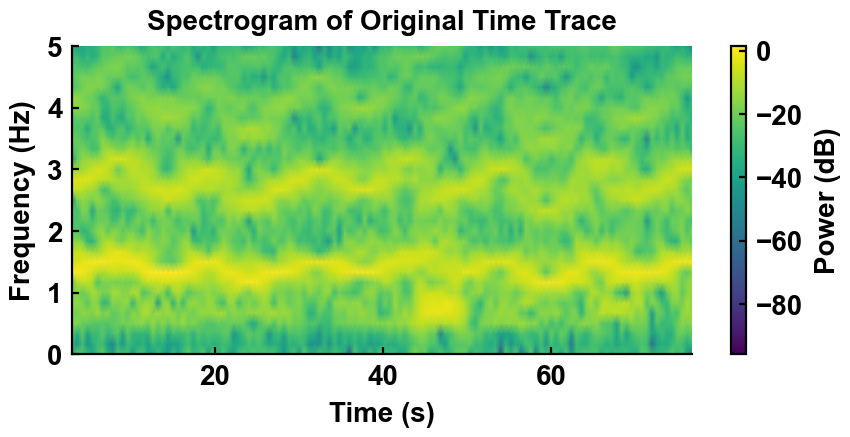

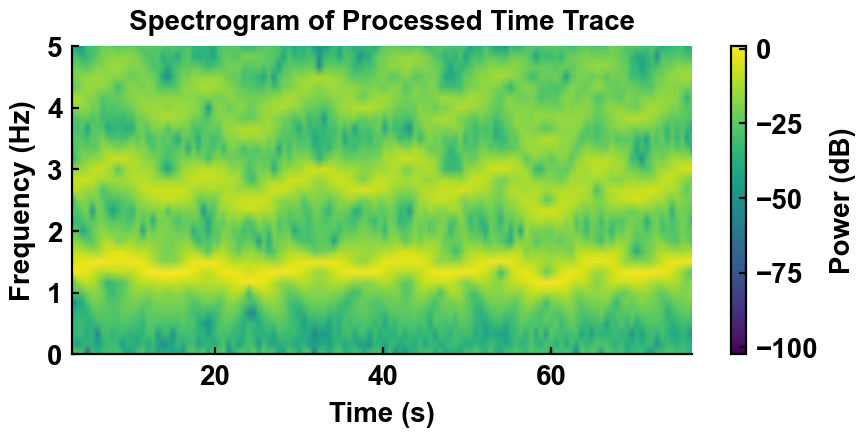

In [10]:
# Spectrograms of the signals, this might take a long time
plot_spectrogram(time_trace, fs_data, title_text="Spectrogram of Original Time Trace")
plot_spectrogram(processed_time_trace, fs_target, title_text="Spectrogram of Processed Time Trace")


## 4. Process signal with other methods

In addition to the LSTM model, we compare against several conventional signal processing approaches:  

- **Temporal Derivative Distribution Repair (TDDR):** A robust fNIRS motion artifact correction algorithm (used in the paper).  
- **Wavelet filtering:** Removes high- and/or low-frequency coefficients from the wavelet decomposition (used in the paper).
- **Savitzky–Golay filter:** A smoothing filter that can be tried (commented out here).  
- **NeuroKit2’s `ppg_clean`:** A library-based PPG cleaning method (commented out here).  

These methods provide baselines for comparison, helping assess how well the deep learning approach performs relative to classical signal processing techniques.


In [11]:
# TDDR (DOI: 10.1016/j.neuroimage.2018.09.025).
_, tddr_corrected, _, _ = TDDR(time_trace.squeeze(), fs_target, 2)

# Savitzky-Golay filter (optional)
# from scipy.signal import savgol_filter
# sg_corrected = savgol_filter(time_trace.squeeze(), window_length=51, polyorder=5)

# NeuroKit2 PPG cleaning (optional)
# Requires the neurokit2 package.
# import neurokit2 as nk
# nk_corrected = nk.ppg_clean(time_trace.squeeze(), sampling_rate=fs_target, method='elgendi')


In [12]:
# Wavelet filtering
# Step 1: Display frequency bands and maximum decomposition level
wavelet_name='db6'
display_frequency_bands(time_trace.squeeze(), sampling_frequency=fs_target, wavelet_name=wavelet_name)

Wavelet 'db6', fs=50.0 Hz; max level=8
Level 1: 12.50–25.00 Hz
Level 2: 6.25–12.50 Hz
Level 3: 3.12–6.25 Hz
Level 4: 1.56–3.12 Hz
Level 5: 0.78–1.56 Hz
Level 6: 0.39–0.78 Hz
Level 7: 0.20–0.39 Hz
Level 8: 0.10–0.20 Hz


In [13]:
# Step 2: Denoise by zeroing out a fraction of wavelet coefficients
# - selected_levels: which decomposition levels to process
# - percentages: % of coefficients removed
# - remove_both_sides=True: removes both high and low extremes
wt_corrected = wavelet_denoise(time_trace.squeeze(), sampling_frequency=fs_target, selected_levels=[4,5],
                               wavelet_name=wavelet_name, percentages=1, reconstruct_all_bands=False, remove_both_sides=True)

Wavelet='db6', fs=50.0 Hz
  Level 4: 1.56–3.12 Hz
  Level 5: 0.78–1.56 Hz


In [14]:
# Overlay raw, TDDR-corrected, Wavelet-corrected, and LSTM-processed signals.
t = np.arange(0, processed_time_trace.shape[1]) / fs_target
fig = go.Figure()

# Add the traces for each signal
fig.add_trace(go.Scatter(x=t, y=time_trace.squeeze(), mode='lines', name='Raw', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=t, y=tddr_corrected, mode='lines', name='TDDR', line=dict(color='red')))
fig.add_trace(go.Scatter(x=t, y=wt_corrected, mode='lines', name='Wavelet', line=dict(color='green')))
fig.add_trace(go.Scatter(x=t, y=processed_time_trace.squeeze(), mode='lines', name='LSTM', line=dict(color='blue')))
# fig.add_trace(go.Scatter(x=t, y=sg_corrected, mode='lines', name='Savitzky-Golay', line=dict(color='grey')))
# fig.add_trace(go.Scatter(x=t, y=nk_corrected, mode='lines', name='Neurokit', line=dict(color='purple')))

fig.update_layout(
    title="Signal Comparison: Conventional Methods vs LSTM",
    xaxis_title="Time (s)",
    yaxis_title="Amplitude",
    legend=dict(x=0.01, y=0.99),  # Position legend at the top left
    width=1200,
    height=600,
)
fig.show()


### Identify and visualize low-SNR regions

In this subsection, we automatically detect low SNR regions (also see section 3) in the time trace and highlight them in the figure.  
This corresponds to the results figure in the paper, which provides both a global overview and detailed examples of artifact-induced distortions.

**Workflow:**
1. Use `extract_low_snr_regions()` to find regions where the SNR drops below a chosen threshold.  
2. Select the worst `n_regions` (based on minimum SNR), expand their time bounds slightly, and sort them chronologically.  
3. Plot the full time trace with shaded artifact regions (top panel), and zoom into selected regions (bottom row).  


In [15]:
# Step 1: automatically extract candidate low-SNR regions
# Returns start/end times for regions where SNR < threshold,
# sorted from worst (lowest SNR) to best.
low_snr_regions = extract_low_snr_regions(time_trace.squeeze(), processed_time_trace.squeeze(), window_size=50, step_size=25, fs=50, threshold=None)
print("Low SNR Regions (start time, end time):", low_snr_regions,'\n')

# Step 2: expand each region by a small buffer (in seconds) for better visualization
buffer_time = 1 # seconds
regions_to_shade = []
for start_time, end_time in low_snr_regions:
    # Decrease the start time and increase the end time
    new_start_time = max(0, start_time - buffer_time)  # Ensure start time does not go below 0
    new_end_time = end_time + buffer_time
    regions_to_shade.append((new_start_time, new_end_time))

# Step 3: pick the worst few regions to plot (e.g., top 4)
n_regions = 4
if len(regions_to_shade) >= n_regions:
    regions_to_shade = regions_to_shade[0:n_regions]

# Sort the regions chronologically
regions_to_shade = sorted(regions_to_shade, key=lambda x: x[0])
print("Regions to shade (start time, end time):", regions_to_shade)

# For paper figures, we specified the regions manually, such as:
# regions_to_shade = [(3.0, 7.0), (13.0, 21.0), (37.0, 43.0), (58.0, 64.0)]

# But for demonstration purpose, we will just use worst four regions indentified automatically.


Low SNR Regions (start time, end time): [(45.5, 49.0), (65.5, 69.0), (77.5, 79.0), (63.5, 65.0), (53.5, 55.0), (9.0, 10.5), (44.0, 45.5), (17.0, 18.5), (3.0, 4.5), (42.5, 44.0), (79.0, 80.0), (0.0, 2.0)] 

Regions to shade (start time, end time): [(44.5, 50.0), (62.5, 66.0), (64.5, 70.0), (76.5, 80.0)]


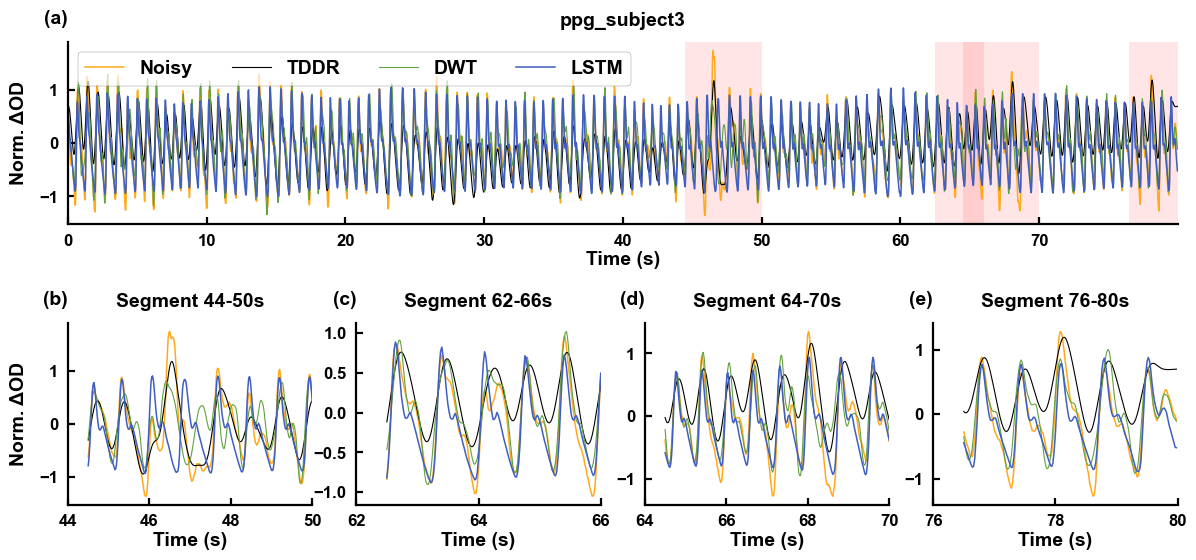

In [16]:
# Non-interactive version as shown in the paper
t = np.arange(0, processed_time_trace.shape[1]) / fs_target

# Create a GridSpec with 2 rows and n columns:
#   Top row: full time trace
#   Bottom row: zoomed-in regions of low SNR
fig = plt.figure(figsize=(7.16, 3))
gs = gridspec.GridSpec(2, len(regions_to_shade), height_ratios=[1, 1])

# Full time trace on the entire top row (spanning all columns)
ax_full_trace = fig.add_subplot(gs[0, :])
ax_full_trace.plot(t, time_trace.squeeze(), label='Noisy', color=color5[2], linewidth=0.55)
ax_full_trace.plot(t, tddr_corrected.squeeze(), label='TDDR', color='k', linewidth=0.4)
ax_full_trace.plot(t, wt_corrected.squeeze(), label='DWT', color=color5[3], linewidth=0.4)
ax_full_trace.plot(t, processed_time_trace.squeeze(), label='LSTM', color=color5[1], linewidth=0.55)

# Shade artifact regions
for start, end in regions_to_shade:
    ax_full_trace.axvspan(start, end, facecolor='red', edgecolor='none', alpha=0.1, label="")

ax_full_trace.set_title(figure_title, fontsize=7)
ax_full_trace.set_xlabel('Time (s)', fontsize=7, labelpad=1)
ax_full_trace.set_ylabel('Norm. ΔOD', fontsize=7)
ax_full_trace.spines['top'].set_visible(False)
ax_full_trace.spines['right'].set_visible(False)
ax_full_trace.tick_params(axis='both', which='major', labelsize=6)
ax_full_trace.set_xlim([t[0],t[-1]])

lgd = ax_full_trace.legend(fontsize=7,frameon=True, framealpha=0.7, ncol=4, loc="upper left")
lgd.get_frame().set_linewidth(0.1)

# Add label (a) to the full time trace subplot
ax_full_trace.text(0, 1.18, '(a)', transform=ax_full_trace.transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# Zoomed-in views in the bottom row
for i, (start, end) in enumerate(regions_to_shade):
    ax = fig.add_subplot(gs[1, i])
    mask = (t >= start) & (t <= end)
    ax.plot(t[mask], time_trace.squeeze()[mask], label='Noisy', color=color5[2], linewidth=0.55)
    ax.plot(t[mask], tddr_corrected.squeeze()[mask], label='TDDR', linestyle='-', color='k', linewidth=0.4)
    ax.plot(t[mask], wt_corrected.squeeze()[mask], label='DWT', linestyle='-', color=color5[3], linewidth=0.4)
    ax.plot(t[mask], processed_time_trace.squeeze()[mask], label='LSTM', color=color5[1], linewidth=0.55)
    ax.set_title(f'Segment {int(start)}-{int(end)}s', fontsize=7)
    ax.set_xlabel('Time (s)', fontsize=7, labelpad=1)
    ax.set_ylabel('Norm. ΔOD', fontsize=7) if i == 0 else ax.set_ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_xticks(np.arange(np.floor(t[mask][0]), np.ceil(t[mask][-1])+1, 2))
    ax.set_xlim([np.floor(t[mask][0]), np.ceil(t[mask][-1])])
    # Add subplot labels (b), (c), ...
    ax.text(0, 1.18, f'({chr(98 + i)})', transform=ax.transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# Adjust layout
plt.subplots_adjust(wspace=0.18, hspace=0.55)  # wspace and hspace control the spacing

# Save figure if needed
# plt.savefig('fig11_nirs_fiber_shaking.png', dpi=600, bbox_inches='tight')

plt.show()


## 5. Pulse segmentation and waveform averaging

We use the cleaned LSTM output to detect pulse boundaries (valleys), which are then used to segment both the raw and processed signals into individual beats. From these segments, we compute mean ± STD waveforms. This provides a summary of the pulse morphology and an quality check on preprocessing and normalization.

**Workflow:**
1. Detect valleys on the processed trace (more stable than on raw data).  
2. Use valley indices to segment both raw and processed signals into pulses.  
3. Optionally apply z-score filtering to remove outlier beats.  
4. Compute average and standard deviation waveforms; visualize with shaded error bands.

**Note:** If preprocessing/normalization is appropriate, the averaged raw and LSTM-processed pulses should have similar amplitudes and lie roughly in [−1, 1].


In [17]:
# Find Valleys
# - 'prominence' affects sensitivity; 'distance' ~ half (or less) a cardiac cycle at fs_target.
_, valleys = find_peaks_and_valleys(processed_time_trace.squeeze(), prominence=0.25, distance=fs_target/2)

# Plot Noisy and Clean Signal with Pulse Boundaries
# Note: For the interactive plots, plotting many vertical lines can be slow for long signals.
plot_signals_with_boundaries(time_trace.squeeze(), processed_time_trace.squeeze(), fs_target, valleys, title="Noisy and Clean Signal with Pulse Boundaries")


In [18]:
# Segment pulses from the noisy time trace
segmented_pulses_noisy = segment_pulses(time_trace.squeeze(), valleys)

# Segment pulses from the processed time trace
segmented_pulses_processed = segment_pulses(processed_time_trace.squeeze(), valleys)

# Calculate pulse mean and std (unfiltered set)
mean_pulse_noisy, std_pulse_noisy = calculate_weighted_mean_std(segmented_pulses_noisy)
mean_pulse_processed, std_pulse_processed = calculate_weighted_mean_std(segmented_pulses_processed)

# Use z-score filtering to remove pulses outliers
# Threshold=2 is a typical starting point; adjust per modality and SNR.
filtered_pulses_noisy, weights_noisy = z_score_filter(segmented_pulses_noisy, z_threshold=2)
filtered_pulses_processed, weights_processed = z_score_filter(segmented_pulses_processed, z_threshold=2)

# Calculate pulse mean and std (filtered set)
filtered_mean_pulse_noisy, filtered_std_pulse_noisy = calculate_weighted_mean_std(filtered_pulses_noisy)
filtered_mean_pulse_processed, filtered_std_pulse_processed = calculate_weighted_mean_std(filtered_pulses_processed)


**Compute similarity metrics:**
- **Pearson correlation (r):** quantifies overall similarity in waveform shape.
- **Absolute difference between time-to-peak (Δ|TTP|):** captures temporal alignment of the main peak.

**Note:**
- The current implementation determines TTP by simply locating the maximum value of each pulse. For noisy signals, this can be unstable. A more robust approach would smooth the waveform before peak detection, or define TTP based on an average across several neighboring values.
- During final code cleanup and dataset preparation, the calculated values of r and Δ|TTP| may differ slightly from those reported in the paper due to minor implementation changes.

In [19]:
# X-axis values (assuming noisy and processed pulses have the same length)
x_noisy = np.arange(len(filtered_mean_pulse_noisy))/fs_target
x_processed = np.arange(len(filtered_mean_pulse_processed))/fs_target

pulse_raw = np.asarray(filtered_mean_pulse_noisy).ravel()
pulse_lstm = np.asarray(filtered_mean_pulse_processed).ravel()
t_pulse = np.asarray(x_noisy).ravel()

# Pearson correlation (shape similarity, mean-centered)
r_pearson = np.corrcoef(pulse_raw, pulse_lstm)[0, 1]

# Time-to-peak
ttp_raw = t_pulse[np.argmax(pulse_raw)]
ttp_lstm = t_pulse[np.argmax(pulse_lstm)]
delta_ttp = abs(ttp_lstm - ttp_raw)

print(f"Pearson r = {r_pearson:.3f}")
print(f"ΔTTP = {delta_ttp:.4f} s")

Pearson r = 0.990
ΔTTP = 0.0000 s


**Plot averaged pulse:**

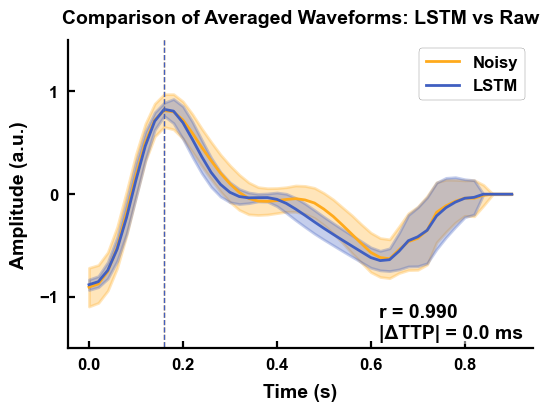

In [20]:
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot()

# Plot noisy mean with shaded std
# Note: If normalization in preprocessing was appropriate, the averaged raw and LSTM-processed
# waveforms should be comparable in amplitude and lie roughly within [-1, 1].
ax.plot(x_noisy, filtered_mean_pulse_noisy, color=color5[2], label='Noisy', linewidth=1)
ax.fill_between(x_noisy, filtered_mean_pulse_noisy - filtered_std_pulse_noisy,
                filtered_mean_pulse_noisy + filtered_std_pulse_noisy, color=color5[2], alpha=0.3)

# Plot processed mean with shaded std
ax.plot(x_processed, filtered_mean_pulse_processed, color=color5[1], label='LSTM', linewidth=1)
ax.fill_between(x_processed, filtered_mean_pulse_processed - filtered_std_pulse_processed,
                filtered_mean_pulse_processed + filtered_std_pulse_processed, color=color5[1], alpha=0.3)


ax.vlines(x = ttp_raw, ymin=-5, ymax=5, color = color5[2], linestyle='--', linewidth=0.5)
ax.vlines(x = ttp_lstm, ymin=-5, ymax=5, color = color5[1], linestyle='--', linewidth=0.5)

ax.text(
    0.98, 0.02,   # near bottom-right corner of the axes
    f"r = {r_pearson:.3f}\n|ΔTTP| = {delta_ttp*1000:.1f} ms",
    transform=ax.transAxes,
    ha="right", va="bottom", fontsize=7, fontweight='bold',
    multialignment="left",   # makes the lines align left *within* the box
    bbox=dict(boxstyle="round,pad=0.1", facecolor="white", alpha=0.5, linewidth=0)
)

# Labels, legend, cosmetics
ax.set_title('Comparison of Averaged Waveforms: LSTM vs Raw', fontsize=7)
ax.set_xlabel('Time (s)', fontsize=7)
ax.set_ylabel('Amplitude (a.u.)', fontsize=7)

lgd = ax.legend(fontsize=6,frameon=True, framealpha=0.7, ncol=1, loc=1)
lgd.get_frame().set_linewidth(0.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=6)
# ax.set_xlim(0, 0.43)
# ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_ylim(-1.5, 1.5)
ax.set_yticks([-1, 0, 1])

# Save the figure if needed
# plt.savefig('averaged_waveform.png', dpi=600, bbox_inches='tight')

plt.show()


**Paper figure: zoomed-in time trace and averaged pulse together**

We will randomly zoom in on a 10-second window when plotting

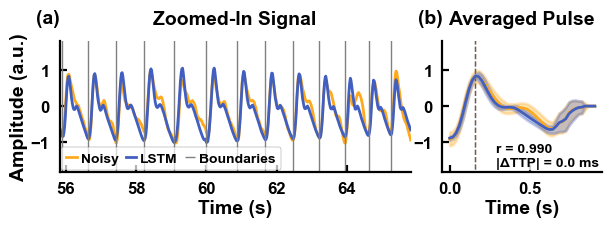

In [21]:
t = np.arange(0, processed_time_trace.shape[1]) / fs_target

# Create a GridSpec with 1 row and n columns
fig = plt.figure(figsize=(3.5, 0.85))
gs = gridspec.GridSpec(1,3)

# Full time trace on the entire top row (spanning both columns)
ax_full_trace = fig.add_subplot(gs[0, 0:2])
ax_full_trace.plot(t, time_trace.squeeze(), label='Noisy', color=color5[2], linewidth=1)
ax_full_trace.plot(t, processed_time_trace.squeeze(), label='LSTM', color=color5[1], linewidth=1)
ax_full_trace.vlines(x = t[valleys], ymin=-5, ymax=5, color = [0.5,0.5,0.5], linestyle='-', linewidth=0.5, label = 'Boundaries')
ax_full_trace.set_title('Zoomed-In Signal', fontsize=7, y=1.0)
ax_full_trace.set_xlabel('Time (s)', fontsize=7, labelpad=1)
ax_full_trace.set_ylabel('Amplitude (a.u.)', fontsize=7, labelpad=1)
ax_full_trace.spines['top'].set_visible(False)
ax_full_trace.spines['right'].set_visible(False)
ax_full_trace.tick_params(axis='both', which='major', labelsize=6)

lgd = ax_full_trace.legend(fontsize=5,frameon=1, framealpha=0.7, ncol=3, loc=3, handlelength=0.75, handletextpad=0.3, borderaxespad=0.08, columnspacing=0.5)
lgd.get_frame().set_linewidth(0.1)

# define a random 10-second window
window_length = 10  # seconds
t_min, t_max = t.min(), t.max()
valid_max_start = t_max - window_length
if valid_max_start <= t_min:
    raise ValueError(f"Time axis is too short for a {window_length}-second window.")
start_time = np.random.uniform(t_min, valid_max_start)
end_time = start_time + window_length

ax_full_trace.set_xlim([start_time,end_time])
ax_full_trace.set_ylim([-1.8,1.8])

# Averaged pulse
ax = fig.add_subplot(gs[0, 2])

# Add verticle lines for ttp
ax.vlines(x = ttp_raw, ymin=-5, ymax=5, color = color5[2], linestyle='--', linewidth=0.5)
ax.vlines(x = ttp_lstm, ymin=-5, ymax=5, color = color5[1], linestyle='--', linewidth=0.5)

# Plot noisy mean with shaded error bars for std
ax.plot(x_noisy, filtered_mean_pulse_noisy, color=color5[2], label='Noisy', linewidth=1)
ax.fill_between(x_noisy, filtered_mean_pulse_noisy - filtered_std_pulse_noisy,
                filtered_mean_pulse_noisy + filtered_std_pulse_noisy, color=color5[2], alpha=0.3)

# Plot processed mean with shaded error bars for std
ax.plot(x_processed, filtered_mean_pulse_processed, color=color5[1], label='LSTM', linewidth=1)
ax.fill_between(x_processed, filtered_mean_pulse_processed - filtered_std_pulse_processed,
                filtered_mean_pulse_processed + filtered_std_pulse_processed, color=color5[1], alpha=0.3)

ax.text(
    0.98, 0.02,   # near bottom-right corner of the axes
    f"r = {r_pearson:.3f}\n|ΔTTP| = {delta_ttp*1000:.1f} ms",
    transform=ax.transAxes,
    ha="right", va="bottom", fontsize=5, fontweight='bold',
    multialignment="left",   # makes the lines align left *within* the box
    bbox=dict(boxstyle="round,pad=0.1", facecolor="white", alpha=0.8, linewidth=0)
)


# Set titles, labels, and customize the axes
ax.set_title('Averaged Pulse', fontsize=7, y=1.0)
ax.set_xlabel('Time (s)', fontsize=7, labelpad=1)
# ax.set_ylabel('Normalized PPG (a.u.)', fontsize=7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=6)
# ax.set_xticks(np.arange(0,0.9,0.2))
ax.set_ylim(-1.8, 1.8)


# Add labels
ax_full_trace.text(0, 1.24, '(a)', transform=ax_full_trace.transAxes, fontsize=7, fontweight='bold', va='top', ha='right')
ax.text(0, 1.24, '(b)', transform=ax.transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# Save the figure
# save_name = 'zoomed_in_signal_and_avg_pulse.png'
# plt.savefig(save_name, dpi=600, bbox_inches='tight')

plt.show()


**Note:**
- Please refer to the companion notebook on **benchmarking the LSTM with synthetic data**, which provides:  
    - Utilities for aligning signals to a common time axis (pulse/IBI/HR interpolation)  
    - HR matching routines  
    - Peak/valley detection tools  
    - Smoothing and comparison functions  

These utilities would be useful practical use cases.